In [ ]:
###### Titanic Kaggle ######  || ##### Top 16 % ##### || ##### Ensemble Learning #####

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score  
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

/Users/manpreetsi/opt/anaconda3/envs/spyder/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [2]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [3]:
feature_set = pd.DataFrame(data_train.columns)[data_train.columns != 'Survived'].values.ravel().tolist()
print(feature_set)

['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [4]:
data_test['Survived'] = 0

In [5]:
data_train['target_category'] = 1
data_test['target_category'] = 2

In [6]:
data = pd.concat([data_train,data_test], axis=0)
data.index = range(len(data))
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,target_category
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [7]:
list(data_train.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'target_category']

In [8]:
""" EXPLORE THE DATA """

' EXPLORE THE DATA '

In [9]:
## Survival vs Gender ##
"""More percent of females have survived"""

'More percent of females have survived'

In [10]:
data_train['died'] = 1- data_train['Survived']

In [11]:
data_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
data_train.groupby('Sex')[['Survived','died']].agg('sum')

,Survived,died
Sex,,
female,233,81
male,109,468


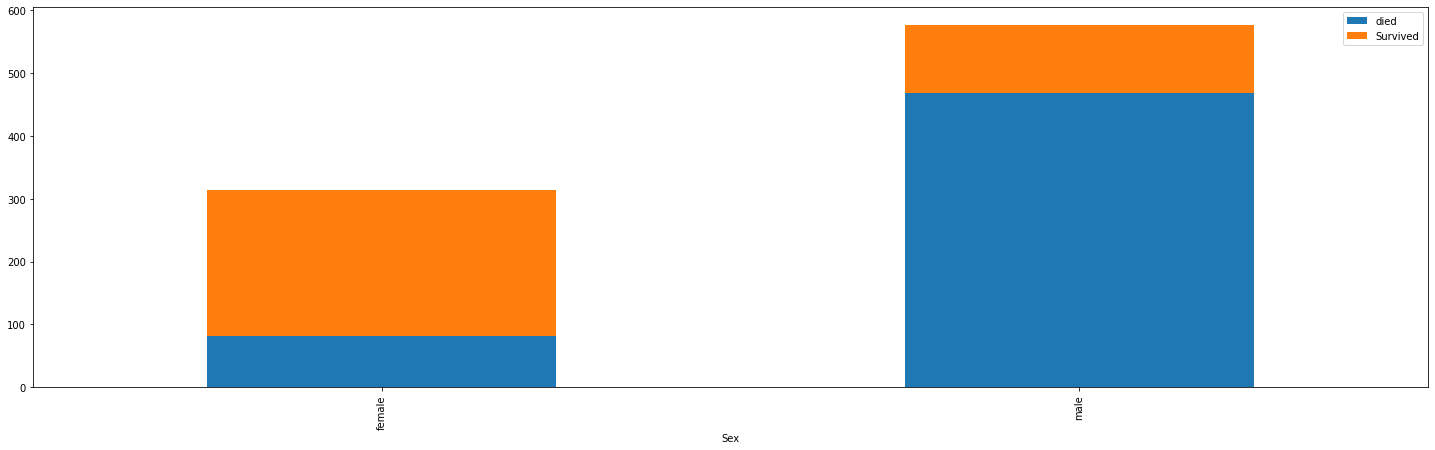

In [13]:
data_train.groupby('Sex').agg('sum')[['died','Survived']].plot(kind='bar', figsize=(25, 7),stacked=True);

In [14]:
## Survival vs Age ##
"""Young people have more survival rate, especially in males. The relaiton is not strong as such"""

'Young people have more survival rate, especially in males. The relaiton is not strong as such'

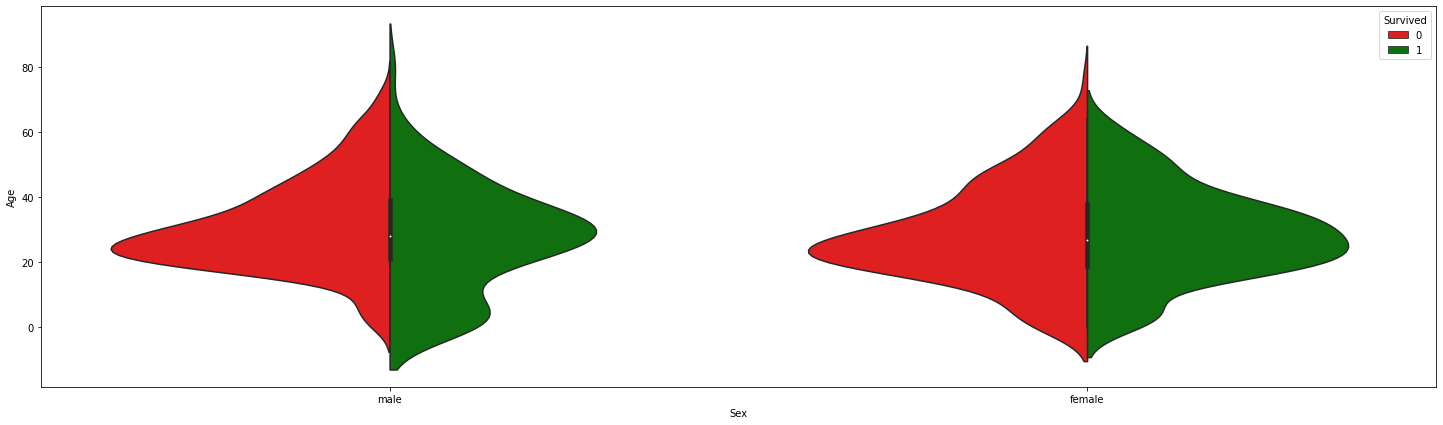

In [15]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

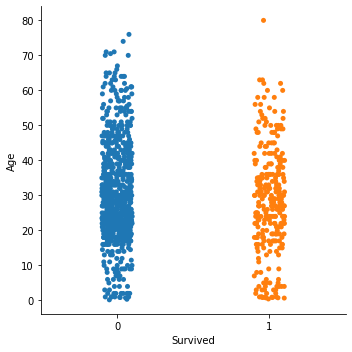

In [16]:
sns.catplot(x="Survived", y="Age", data=data);

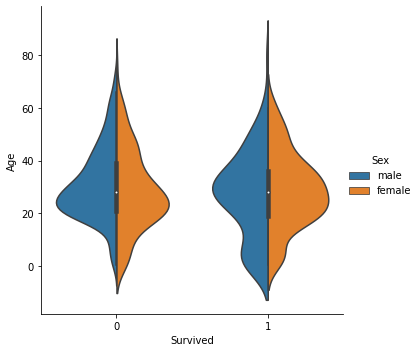

In [17]:
sns.catplot(x="Survived", y="Age", hue="Sex",
            kind="violin", split=True, data=data);

In [18]:
## Survival vs Fare ##
""" Higher Fare Passengers have higher survival rate/less death rate"""

' Higher Fare Passengers have higher survival rate/less death rate'

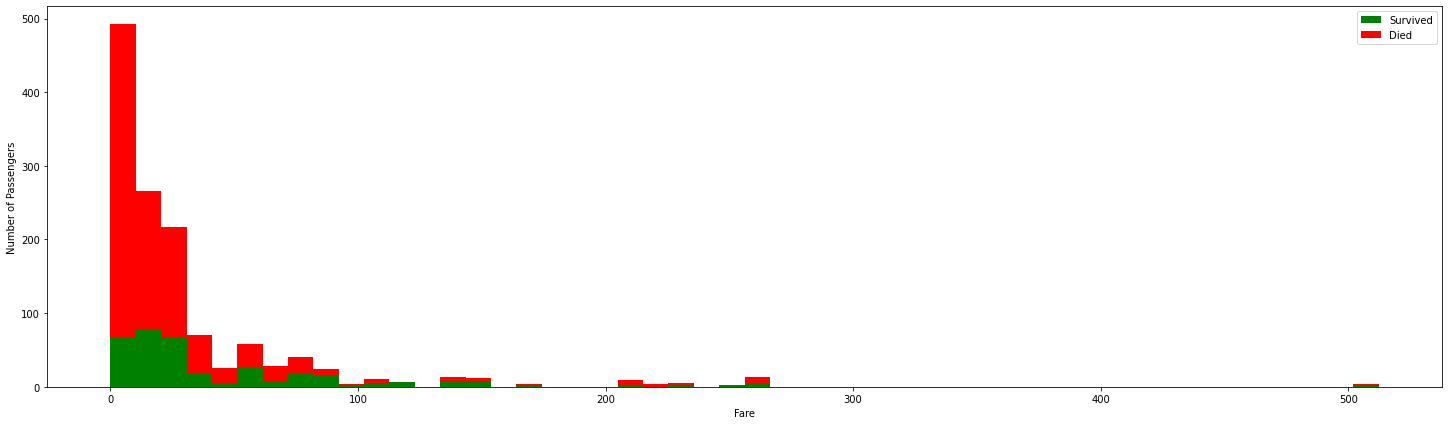

In [19]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Died'])
plt.xlabel('Fare')
plt.ylabel('Number of Passengers')
plt.legend();

In [20]:
""" FEATURE ENGINEERING"""

' FEATURE ENGINEERING'

In [21]:
data[data.target_category==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Name             891 non-null    object 
 4   Sex              891 non-null    object 
 5   Age              714 non-null    float64
 6   SibSp            891 non-null    int64  
 7   Parch            891 non-null    int64  
 8   Ticket           891 non-null    object 
 9   Fare             891 non-null    float64
 10  Cabin            204 non-null    object 
 11  Embarked         889 non-null    object 
 12  target_category  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ KB


In [22]:
data[data.target_category==2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Survived         418 non-null    int64  
 2   Pclass           418 non-null    int64  
 3   Name             418 non-null    object 
 4   Sex              418 non-null    object 
 5   Age              332 non-null    float64
 6   SibSp            418 non-null    int64  
 7   Parch            418 non-null    int64  
 8   Ticket           418 non-null    object 
 9   Fare             417 non-null    float64
 10  Cabin            91 non-null     object 
 11  Embarked         418 non-null    object 
 12  target_category  418 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 45.7+ KB


In [23]:
## Pclass :-
data['Pclass'].value_counts()

3    709
1    323
2    277
Name: Pclass, dtype: int64

In [24]:
dummies = pd.get_dummies(data['Pclass'],prefix='Pclass')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Pclass'],axis=1,inplace=True)

In [25]:
## Sex
data['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [26]:
dummies =pd.get_dummies(data['Sex'],prefix='Sex')
dummies = dummies.astype('category',copy = False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Sex'],axis=1,inplace=True)

In [27]:
## Imputing null values with median

In [28]:
data.loc[data.target_category==1,'Age']= data[data.target_category==1]['Age'].fillna(data[data.target_category==1]['Age'].median())
data.loc[data.target_category==2,'Age']= data[data.target_category==2]['Age'].fillna(data[data.target_category==2]['Age'].median())
data.loc[data.target_category==2,'Fare']= data[data.target_category==2]['Fare'].fillna(data[data.target_category==2]['Fare'].median())

In [29]:
## Categorizing Fare :-
## Fare > 100 
## Fare <= 100

In [30]:
data.loc[data.Fare >= 100,"Fare_100_plus"]=1
data.loc[data.Fare < 100,"Fare_100_plus"]=0
data['Fare_100_plus'].value_counts()
dummies = pd.get_dummies(data['Fare_100_plus'],prefix='Fare_100_plus')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Fare_100_plus'],axis=1,inplace=True)

In [31]:
##Sibsp
data['SibSp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [32]:
dummies = pd.get_dummies(data['SibSp'],prefix='SibSp')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['SibSp'],axis=1,inplace=True)

In [33]:
## Parch
data['Parch'].value_counts()

0    1002
1     170
2     113
3       8
5       6
4       6
9       2
6       2
Name: Parch, dtype: int64

In [34]:
dummies = pd.get_dummies(data['Parch'],prefix='Parch')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Parch'],axis=1,inplace=True)

In [35]:
# Categorizing Cabins, taking first character of cabin information
data['Cabin'].value_counts()

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
C78                4
F2                 4
                  ..
C132               1
C91                1
A19                1
E60                1
D6                 1
Name: Cabin, Length: 186, dtype: int64

In [36]:
data['Cabin_Class'] = data['Cabin'].str.get(0)
data['Cabin_Class'].value_counts()
data['Cabin_Class'] = data['Cabin_Class'].fillna(0)
dummies = pd.get_dummies(data['Cabin_Class'],prefix='Cabin_Class')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Cabin_Class'],axis=1,inplace=True)
data.drop(['Cabin'],axis=1,inplace=True)

In [37]:
## Embarked
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [38]:
data['Embarked'].isnull().value_counts()
data['Embarked'] = data['Embarked'].fillna(0)
dummies = pd.get_dummies(data['Embarked'],prefix='Embarked')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['Embarked'],axis=1,inplace=True)

In [39]:
## Getting Title information from Name

In [40]:
titles = []
for name in data['Name']:
    titles.append(name.split(',')[1].split('.')[0].strip())    
set(titles)

{'Capt',
 'Col',
 'Don',
 'Dona',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir',
 'the Countess'}

In [41]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Dona" : "Miss",
    "Dr": "Officer",
    "Jonkheer": "Royalty",
    "Lady" : "Royalty",
    "Master" : "Master",
    "Miss" : "Miss",
    "Mlle": "Miss",
    "Mme": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Ms": "Mrs",
    "Rev": "Officer",
    "Sir" : "Royalty",
    "the Countess":"Royalty"    
}

In [42]:
data['title'] = data['Name'].map(lambda x : x.split(',')[1].split('.')[0].strip())
data['title'] = data.title.map(Title_Dictionary) 
data['title'].value_counts()
dummies = pd.get_dummies(data['title'],prefix='title')
dummies = dummies.astype('category',copy=False)
data = pd.concat([data,dummies],axis=1)
data.drop(['title'],axis=1,inplace=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 48 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   PassengerId        1309 non-null   int64   
 1   Survived           1309 non-null   int64   
 2   Name               1309 non-null   object  
 3   Age                1309 non-null   float64 
 4   Ticket             1309 non-null   object  
 5   Fare               1309 non-null   float64 
 6   target_category    1309 non-null   int64   
 7   Pclass_1           1309 non-null   category
 8   Pclass_2           1309 non-null   category
 9   Pclass_3           1309 non-null   category
 10  Sex_female         1309 non-null   category
 11  Sex_male           1309 non-null   category
 12  Fare_100_plus_0.0  1309 non-null   category
 13  Fare_100_plus_1.0  1309 non-null   category
 14  SibSp_0            1309 non-null   category
 15  SibSp_1            1309 non-null   category
 16  SibSp_

In [44]:
feature_set_train = list(filter(lambda x : x not in ['Name','Ticket','PassengerId','target_category','died'],list(data.columns)))
feature_set_test = list(filter(lambda x : x not in ['Name','Ticket','Survived','PassengerId','target_category','died'],list(data.columns)))

In [45]:
## variable reduction

In [46]:
zero_var_name =[]

In [47]:
for name in feature_set:
    try:
        if np.var(data[data.target_category==1][name])==0:
            zero_var_name.append(name)
    except:
        continue    

In [48]:
mycorr = data[data.target_category==1][feature_set_test].corr(method = 'pearson').abs()
upper = mycorr.where(np.triu(np.ones(mycorr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>.99)]
to_drop

[]

In [49]:
training = data[feature_set_train][data.target_category==1] 
training.index = range(len(training))
test = data[feature_set_test][data.target_category==2]
test.index = range(len(test))

In [50]:
training.isnull().any().sum()

0

In [51]:
training.isna().any().sum()

0

In [52]:
test.isnull().any().sum()

0

In [53]:
test.isna().any().sum()

0

In [54]:
data_test['Sex'].value_counts()

male      266
female    152
Name: Sex, dtype: int64

In [55]:
data_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [56]:
##training = pd.concat([training.sample(n=400),training],axis=0)

In [57]:
##training.index = range(len(training))

In [58]:
x = training.loc[:,training.columns !='Survived']
y = pd.DataFrame(training['Survived'],columns=['Survived'])

In [395]:
training.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Fare_100_plus_0.0,Fare_100_plus_1.0,...,Embarked_0,Embarked_C,Embarked_Q,Embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Officer,title_Royalty
0,0,22.0,7.2500,0,0,1,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1,38.0,71.2833,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,1,35.0,53.1000,1,0,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,0
4,0,35.0,8.0500,0,0,1,0,1,1,0,...,0,0,0,1,0,0,1,0,0,0


In [396]:
## Taking training sampling as +400 
rf = RandomForestClassifier(max_depth= 6, min_samples_leaf=2,min_weight_fraction_leaf=.002,criterion='entropy')
print(np.mean(cross_val_score(rf, x,y.values.ravel(), scoring="accuracy", cv=10)))

0.8294132334581773


In [397]:
rf_model = rf.fit(x, y.values.ravel())
scoring_pred = pd.DataFrame(rf_model.predict(test),columns=['Survived'])
scoring_pass_id = pd.DataFrame( data['PassengerId'][data.target_category==2], columns = ['PassengerId'])
scoring_pass_id.index = range(len(scoring_pass_id))
scoring_rf_df = pd.concat([scoring_pass_id,scoring_pred['Survived']], axis =1)  
scoring_rf_df.to_csv("scoring_rf_400.csv")

In [398]:
scoring_rf_df
## This result has given .79425 on test data after submission i.e. Top 16%

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [399]:
## Taking training sampling as +400 
lgbm = lgb.LGBMClassifier(learning_rate =.2,max_depth = 5,scale_pos_weight=1,min_split_gain=0.1)   
print(np.mean(cross_val_score(lgbm, x,y.values.ravel(), scoring="accuracy", cv=10)))

0.8339700374531833


In [404]:
lgbm_model = lgbm.fit(x, y.values.ravel())
scoring_pred = pd.DataFrame(lgbm_model.predict(test),columns=['Survived'])
scoring_pass_id = pd.DataFrame( data['PassengerId'][data.target_category==2], columns = ['PassengerId'])
scoring_pass_id.index = range(len(scoring_pass_id))
scoring_lgbm_df = pd.concat([scoring_pass_id,scoring_pred['Survived']], axis =1)  
scoring_lgbm_df.to_csv("scoring_lgbm.csv")

In [400]:

gbm = GradientBoostingClassifier(n_estimators=200,min_samples_split=2,
                                        min_samples_leaf=2,max_depth=6,
                                        max_features='auto',learning_rate=.07,
                                        random_state=123)
  
print(np.mean(cross_val_score(gbm, x,y.values.ravel(), scoring="accuracy", cv=10)))

0.8227215980024969


In [401]:
gbm_model = gbm.fit(x, y.values.ravel())
scoring_pred = pd.DataFrame(gbm_model.predict(test),columns=['Survived'])
scoring_pass_id = pd.DataFrame( data['PassengerId'][data.target_category==2], columns = ['PassengerId'])
scoring_pass_id.index = range(len(scoring_pass_id))
scoring_gbm_df = pd.concat([scoring_pass_id,scoring_pred['Survived']], axis =1)  
scoring_gbm_df.to_csv("scoring_gbm_400.csv")

In [402]:
gbm_feature_importances = pd.DataFrame(gbm_model.feature_importances_*100,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [403]:
gbm_feature_importances

,importance
title_Mr,34.157250
Fare,24.102339
Age,16.597113
Pclass_3,8.632800
title_Officer,3.688705
Cabin_Class_0,1.422217
Pclass_2,1.093108
SibSp_1,0.914842
Embarked_S,0.830156
SibSp_0,0.760268


In [93]:
scoring_gbm_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [275]:
"""  Implementing my neural network package  """


In [59]:
pip install customdnn

Processing ./Library/Caches/pip/wheels/0a/be/07/ac2ff8333111e3a383aa6eb0bd99020d74dd3d008d451d3958/customdnn-1.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [60]:
from customdnn.network_train import SplitData,TrainingDeepNetwork
from customdnn.network_predict import PredictDeepNetwork

In [61]:
a = SplitData()

In [62]:
x_train,x_test,y_train,y_test = a.split_train_test(x, y, 5)

In [63]:
y_test

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        0]])

In [64]:
param = {}
b = TrainingDeepNetwork()

You have choosen the default network having   4  layers with  3  hidden layers.

If you wish to update the network design, then press N to start over 
         #########  or  ######### 
Press Y to continue entering the number of neurons for each layer 
Y
Enter number of neurons for hidden layer 1 :
96
Enter number of neurons for hidden layer 2 :
22
Enter number of neurons for hidden layer 3 :
8
Network Modeling started at  2020-05-05 14:35:20.538973 

|                    COMPLETE!                      | 100%

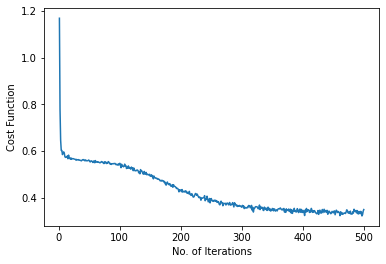



################ Cost Graph for training dataset has been plotted ! ################ 



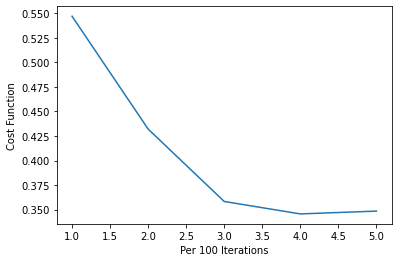

################ Cost Graph per 100 iterations for training dataset has been plotted ! ################

 Training of the network completed at  2020-05-05 14:35:29.501522  
 Minimum cost function value in training is  0.32119811341157306


In [66]:
##Gradient Optimization Algorithm = GDM
param = b.train_network(x_train, y_train,learning_rate=.01,beta1=.9,beta2=.999,
                        batch_size=32,network_size=3,gradient="GDM",epoch_num=500)

In [67]:
c = PredictDeepNetwork()

In [69]:
y_pred_prob = c.predict_proba(x_test, param,network_size=3)

In [70]:
y_pred_prob

,Pred_Prob,Predicted
0,0.473802,0.0
1,0.448358,0.0
2,0.119960,0.0
3,0.119960,0.0
4,0.962507,1.0
5,0.119960,0.0
6,0.119960,0.0
7,0.802095,1.0
8,0.119960,0.0
9,0.119960,0.0


In [344]:
y_pred_prob_df = pd.DataFrame(y_pred_prob.ravel(),columns=['Pred_Prob'])

In [345]:
y_pred_prob_df.loc[y_pred_prob_df.Pred_Prob >  .5,'Pred']=1
y_pred_prob_df.loc[y_pred_prob_df.Pred_Prob <= .5,'Pred']=0

In [346]:
y_test_df = pd.DataFrame(y_test.ravel())

In [347]:
## accuracy on 5% validation data
accuracy_score(y_test_df,y_pred_prob_df['Pred'])

0.7384615384615385

In [380]:
param = {}
b1 = TrainingDeepNetwork()

You have choosen the default network having   4  layers with  3  hidden layers.

If you wish to update the network design, then press N to start over 
         #########  or  ######### 
Press Y to continue entering the number of neurons for each layer 
Y
Enter number of neurons for hidden layer 1 :
96
Enter number of neurons for hidden layer 2 :
22
Enter number of neurons for hidden layer 3 :
8
Network Modeling started at  2020-05-04 01:36:15.123700 

|                    COMPLETE!                      | 100%

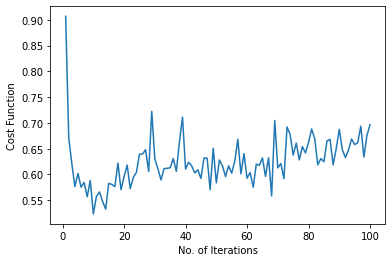



################ Cost Graph for training dataset has been plotted ! ################ 



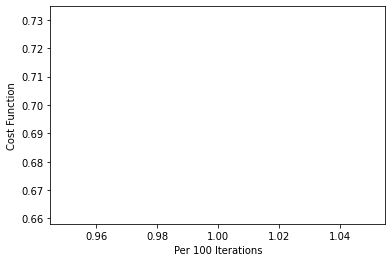

################ Cost Graph per 100 iterations for training dataset has been plotted ! ################

 Training of the network completed at  2020-05-04 01:36:18.570883  
 Minimum cost function value in training is  0.5233141312260958


In [382]:
##Gradient Optimization Algorithm = Adam
param = b1.train_network(x_train, y_train,learning_rate=.01,beta1=.9,beta2=.999,
                        batch_size=32,network_size=3,gradient="Adam",epoch_num=100)

In [383]:
c = PredictDeepNetwork()

In [384]:
y_pred_prob = c.predict_proba(x_test, y_test, param,network_size=3)

In [385]:
y_pred_prob_df = pd.DataFrame(y_pred_prob.ravel(),columns=['Pred_Prob'])

In [386]:
y_pred_prob_df.loc[y_pred_prob_df.Pred_Prob >  .5,'Pred']=1
y_pred_prob_df.loc[y_pred_prob_df.Pred_Prob <= .5,'Pred']=0

In [389]:
y_pred_prob_df

,Pred_Prob,Pred
0,0.119370,0.0
1,0.119370,0.0
2,0.119370,0.0
3,0.119370,0.0
4,0.119370,0.0
...,...,...
60,0.166111,0.0
61,0.999999,1.0
62,1.000000,1.0
63,0.119370,0.0


In [387]:
y_test_df = pd.DataFrame(y_test.ravel())

In [388]:
## accuracy on 5% validation data
accuracy_score(y_test_df,y_pred_prob_df['Pred'])

0.8307692307692308